<h1>Hands On: ML de Clasificación</h1>

En este notebook se explican las técnicas de clasificación del libro hands on ML. Corresponde al capítulo 3 de la sección de Machine Learning, y es una explicación superficial del problema de la clasificación mediante algoritmos de aprendizaje automático. En este capítulo no se profundiza tanto en los algoritmos como en la forma correcta de abordar 
  - Importación de datasets (con el MNIST de ejemplo)
  - Entrenamiento de clasificadores binarios
  - Cross-Validation
  - Métricas: Precision, recall, f1, Curva ROC y AUC_ROC, etc.
  - Clasificación multiclase: one-vs-all, one-vs-one
  - Análisis de errores
  - Clasificación multietiqueta
  - Clasificación multioutput
  
El objetivo es tener una visión general de la forma correcta de abordar los problemas de clasificación, así como de las métricas más utilizadas en los mismos y su significado.


<h3>Imports</h3>

In [1]:
# Imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

# Algoritmos:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score, precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

<h2> Dataset: MNIST </h2>

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])
(70000, 784) (70000,)


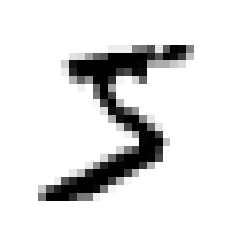

El valor del label es: 5


In [2]:
# Se importa el MNIST:
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())
# Se definen X e y
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
print(X.shape,y.shape)

# Veamos un ejemplo de dato
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
#plt.imshow(some_digit_image)# Veamos un ejemplo de dato
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
#plt.imshow(some_digit_image)
plt.axis("off")
plt.show()
print("El valor del label es: " + str(y[0]))
plt.axis("off")
plt.show()
print("El valor del label es: " + str(y[0]))

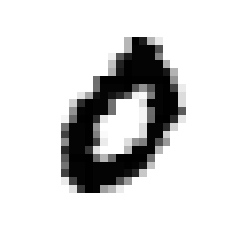

El valor del label es: 0


In [8]:
# Veamos un ejemplo de dato
some_digit = X[37]
some_digit_image = some_digit.reshape(28, 28)# Veamos un ejemplo de dato
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
#plt.imshow(some_digit_image)
plt.axis("off")
plt.show()
print("El valor del label es: " + str(y[0]))
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
#plt.imshow(some_digit_image)
plt.axis("off")
plt.show()
print("El valor del label es: " + str(y[37]))

<h2> Clasificador Binario </h2>

In [4]:
# Se crea un train y un test:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
# Para estudiar clasificadores binarios, construimos un target que sea 1 si el label es 5 y 0 si no lo es
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Entrenamos, por ejemplo, un Stochastic Gradient Descend
sgd_clf = SGDClassifier(random_state=1994)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit]) # Era un 5

array([ True])

<h2> Métricas </h2>

<h3> Cross Validation </h3>

Vamos a estudiar el performance del modelo:

    1.- Cross Validation (estudio en 1- Tecnicas de Modelizacion (K-Nearest-Neighbours) del curso de DS de MS).
    
En el curso de KNN se explica como controlar mas el CV, mediante el StratifiedKFold. Además el Stratified conserva el ratio de representatividad de cada clase dentro del conjunto estudiado.


In [6]:
# Ejemplo Stratified:

skfolds = StratifiedKFold(n_splits=3, random_state=1994)
predicted = []

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    predicted.append(n_correct/len(y_pred))

print(predicted)
    
# Ejemplo con cross_val_score:
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

# La cosa es que estos clasificadores son meh, porque decir que nunca es un 5 daria un 90% de accuracy aprox
# La accuracy es una metrica mala para los clasificadores, sobre todo para skewed datasets (desbalanceados)

[0.9659, 0.95735, 0.94755]


array([0.9659 , 0.95735, 0.94755])

<h2> Matriz de Confusión:<h2> 

<h3>Precision y Recall </h3>

In [7]:
# Primero se hace un cross_val_predict para obtener la prediccion en lugar del score
y_train_pred= cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
# Con Sklearn se saca la confusion matrix
confusion_matrix(y_train_5,y_train_pred)


array([[53581,   998],
       [ 1586,  3835]])

Los términos de la matriz son: 

    True Negatives (TN)      False Positives (FP)
    False Negatives (FN)     True Positives (TP)

Con ellos se forman algunas de las métricas utilizadas en problemas de clasificación:

    Precision: TP/(TP+FP)
    Recall: TP/(TP+FN)

In [8]:
print('La precision es: ' + str(precision_score(y_train_5,y_train_pred)))
print('El recall es: ' + str(recall_score(y_train_5,y_train_pred)))

La precision es: 0.7935030002069108
El recall es: 0.7074340527577938


A veces se combinan ambas en una única métrica: 

    F1 = 2/(1/precision + 1/recall) = 2*(precision*recall)/(precision+recall) = TP/(TP + ((FN+FP)/2))
    
NOTA: La métrica F1 es buena cuanto tanto la precision como el recall son altos!!

In [9]:
print('El F1 Score es: ' + str(f1_score(y_train_5,y_train_pred)))

El F1 Score es: 0.748000780183343


A veces en el tradeoff de precision y recall interesa favorecer una de las dos, por ej si buscas clasificar videos aptos para niños te interesa que la precision sea alta aunque te cargues algunos seguros, o si buscas identificar robos mejor que el recall sea alto aunque a veces tengas falsas alarmas de robo.

Existe un método precision_recall_curve en sklearn, que en funcion de la decision_function te permite calibrar el tradeoff:

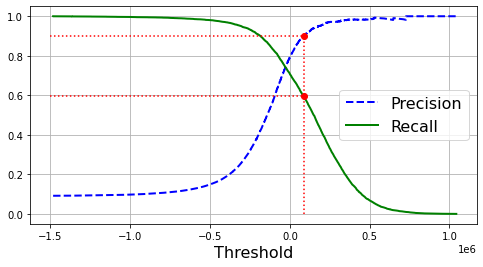

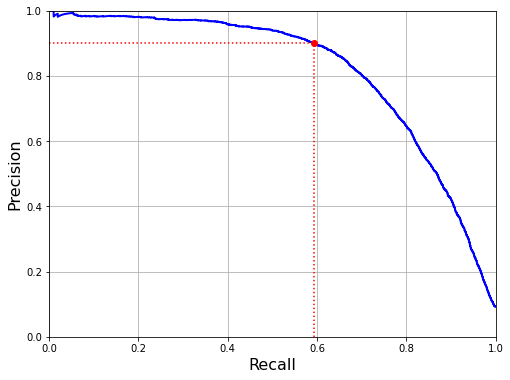

In [10]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

# Lo pintamos para verlo:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    #plt.axis([-100000, 100000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-1500000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-1500000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           

plt.show()



# Tambien se puede pintar la precision contra el recall:

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.5941, 0.5941], [0., 0.9], "r:")
plt.plot([0.0, 0.5941], [0.9, 0.9], "r:")
plt.plot([0.5941], [0.9], "ro")
plt.show()

In [11]:
# Como ejemplo, vamos a ver un clasificador con precision al 90%:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('El threshold de 90% cae en: ' + str(threshold_90_precision))
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('La precision del modelo con este threshold es: ' + str(precision_score(y_train_5, y_train_pred_90)))
print('Y el recall es: '+str(recall_score(y_train_5, y_train_pred_90)))

El threshold de 90% cae en: 86056.39320497435
La precision del modelo con este threshold es: 0.9002235885969816
Y el recall es: 0.5941708171924


<h3>Curva ROC y AUC ROC</h3>

La curva ROC es la curva del ratio de true positives contra el ratio de true negatives (sensitividad vs 1-especificidad)

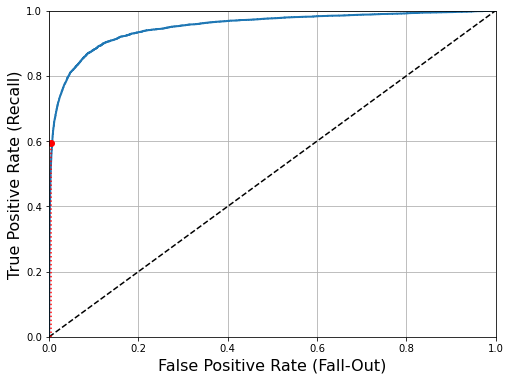

El area bajo la curva ROC es: 0.9514759856617959


In [12]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Se puede pintar usando matplotlib:

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal for neutral model
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.5941], "r:") 
plt.plot([0.0, 4.837e-3], [0.5941, 0.5941], "r:")  
plt.plot([4.837e-3], [0.5941], "ro")               
plt.show()

# Se ve el tradeoff de recall y 1-sensitividad. Para medir como de bueno es un clasificador se utiliza el 
# área bajo la curva:

print('El area bajo la curva ROC es: ' + str(roc_auc_score(y_train_5,y_scores)))


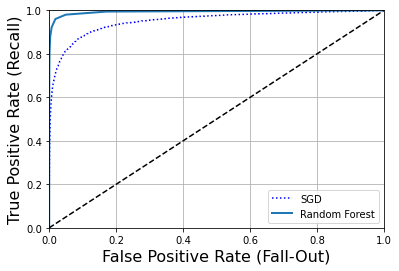

El area bajo la curva ROC es: 0.9935475303422577
La precision del modelo con este threshold es: 0.9671065989847716
Y el recall es: 0.8786201807784542


In [13]:
# Para saber si este AUC ROC es bueno, vamos a entrenar un random forest y a calcular su AUC ROC:

forest_clf = RandomForestClassifier(random_state=1994)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

# Esto te da probabilidades, pero necesitas scores:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# Se plotea junto a la otra para verla:

plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc='lower right')
plt.show()

# Y vemos cuanto vale el AUC_ROC:
print('El area bajo la curva ROC es: ' + str(roc_auc_score(y_train_5,y_scores_forest)))

# Y por ultimo la precision y el recall:
y_prediction_forest = y_probas_forest[:,1]>=0.5
print('La precision del modelo con este threshold es: ' + str(precision_score(y_train_5, y_prediction_forest)))
print('Y el recall es: '+str(recall_score(y_train_5, y_prediction_forest)))

<h2>Clasificación multiclase: one-vs-all, one-vs-one</h2>

One vs All es mas lento, pero es el preferido para la mayoria de algoritmos

One vs One se usa en algoritmos que escalan mal, como el SVM. El problema es que hay que entrenar N*(N-1)/2 clasificadores distintos, pero solo para la muestra de los 2 que estes enfrentando en cada clasificador.

In [14]:
# SKLearn hace la detección de multiclase y elige OvA u OvO según convenga. Por ej:
sgd_clf.fit(X_train,y_train)
print('La prediccion para some_digit es: ' + str(sgd_clf.predict([some_digit])[0]))

# Para ver el procedimiento, se puede usar el metodo decision_function():
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

# La prediccion será el valor maximo del array
print('La prediccion es: ' + str(np.argmax(some_digit_scores)))
print('Siendo las clases: ' + np.array2string(sgd_clf.classes_))
print('Por lo que el valor predicho es: ' + str(sgd_clf.classes_[np.argmax(some_digit_scores)]))

# En este caso hay suerte porque el orden de las clases coincide con los digitos a predecir, pero no suele 
# pasar esto. Las clases y las predicciones no tienen por que seguir el mismo orden.

La prediccion para some_digit es: 5
[[-492185.89482699 -541385.55832415 -469870.59119773  -26441.07076953
  -472028.41846427  221767.24910661 -592104.53445193 -261710.53707885
  -571835.92569147 -654418.63077435]]
La prediccion es: 5
Siendo las clases: [0 1 2 3 4 5 6 7 8 9]
Por lo que el valor predicho es: 5


In [15]:
# Si se quiere forzar a SKLearn a usar OvO o OvA, se pueden usar las clases OneVsOneClassifier y 
# OneVsRestClassifier:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=1994))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict
print('La prediccion para some_digit del OvO es: ' + str(ovo_clf.predict([some_digit])[0]))

# Con un random forest es mucho mas facil porque soporta multiclase:
forest_clf.fit(X_train,y_train)
print('La prediccion para some_digit del Random Forest es: ' + str(forest_clf.predict([some_digit])[0]))
# La probabilidad de cada clase de un RF se ve con el predict_proba:
print(forest_clf.predict_proba([some_digit]))

La prediccion para some_digit del OvO es: 5
La prediccion para some_digit del Random Forest es: 5
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [16]:
# Si se quiere evaluar el clasificador, como siempre, se usa cross validation:
print(cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy'))

# Para mejorarlo se podría hacer algo de preprocesado y eso, por ejemplo estandarizar los datos:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy'))


[0.87627475 0.87984399 0.87628144]
[0.90696861 0.90814541 0.91233685]


<h2> Análisis de Errores </h2>

Si vas a hacer un proyecto real se sigue el esquema típico: explorar data, probar modelos, elegir los mejores, tunear hiperparámetros usando GridSearchCV y automatizar lo posíble.

[[5728    2   24    9   10   47   51    7   40    5]
 [   1 6481   41   22    6   38    8   14  120   11]
 [  65   37 5319   92   84   26   97   57  165   16]
 [  54   42  143 5323    3  228   37   54  143  104]
 [  22   25   34    7 5342   11   58   34   95  214]
 [  75   41   40  198   77 4585  105   26  174  100]
 [  31   26   39    2   47   87 5634    5   47    0]
 [  21   24   70   29   57   12    5 5783   16  248]
 [  54  150   71  142   11  150   54   21 5047  151]
 [  39   33   30   85  154   30    2  192   77 5307]]


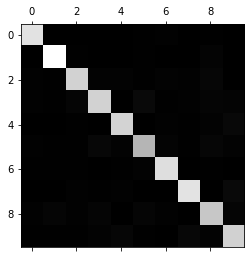

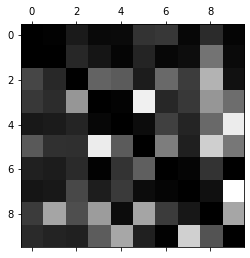

In [17]:
# Supongamos que ya hemos elegido el modelo, vamos a ver si falla algo. Una forma es analizar los tipos de 
# errores que se cometen mediante una confusion_matrix
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
print(conf_mx)

# Para hacerlo mas visible vamos a plotear los resultados:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

# Como son valores absolutos, no se aprecia muy bien qué esta pasando. Vamos a ver el ratio de errores en
# cada clase:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums
# Llenamos la diagonal de 0 solo para ver los errores:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

# Aunque todo esta relativamente bien, se ve que en el 8 y 9 falla mas. Ya es meterse en los datos y ver que 
# pasa ahi.


<h2>Clasificación Multietiqueta</h2>

Consiste en clasificar en mas de una etiqueta a la vez (x ej, es 7, 8 o 9)

In [18]:
# Vamos a ver un ejemplo, de si el digito es grande (7,8,9) o si es impar. Para ello entrenamos un 
# KNeighborsClassifier y lo entrenamos usando esos dos arrays:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

print(knn_clf.predict([some_digit]))
# Genial, es menor a 7 e impar.

# Vamos a ver con CV como actuaria en el global de la muestra:
#y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
#print('El F1 Score del modelo es: ' + str(f1_score(y_multilabel,y_train_knn_pred, average='macro')))

# Lo dejo comentado porque tarda bastante en entrenar

[[False  True]]


<h2>Clasificación Multioutput</h2>

Es una generalización de la clasificación multietiqueta en la que cada etiqueta puede ser multiclass (es decir, tener varios valores)

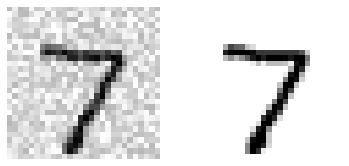

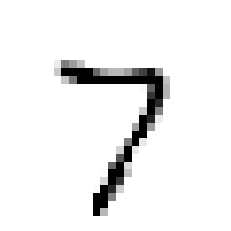

In [19]:
# Como ejemplo, un sistema que le quita el ruido a las imágenes:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

# Pintamos un número con ruido a ver:

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

# Limpiamos la imagen:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

<h2>Ejercicios</h2>

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).

In [ ]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# Tarda muchísimo (aprox 5-6h)
# El resultado es {'n_neighbors': 4, 'weights': 'distance'}
# Da un modelo de 0.9716